In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder


In [26]:
np.random.seed(42)
n = 200

df = pd.DataFrame({
    'employee_id': range(1, 1 + n),
    'age': np.random.randint(22, 65, n).astype(float),
    'salary': np.random.normal(70000, 18000, n),
    'department': np.random.choice(['Sales', 'Engineering', 'HR', 'Marketing', 'Finance'], n),
    'experience_years': np.random.randint(0, 25, n).astype(float),
    'performance_score': np.random.uniform(1,10, n),
    'city': np.random.choice(['kathmandu', 'pokhara', 'bhaktapur', 'ktm', 'pkr', 'KATHMANDU', np.nan], n)
})

df.loc[np.random.choice(df.index, 15, replace=False), 'age'] = np.nan
df.loc[np.random.choice(df.index, 20, replace=False), 'salary'] = np.nan
df.loc[np.random.choice(df.index, 10, replace=False), 'experience_years'] = np.nan

idx = np.random.choice(df.index, 8, replace=False)
df.loc[idx[:4], 'salary'] = [250000, 280000, 5000, 3000]
df.loc[idx[4:], 'age'] = [95, 98, 15, 16]

df = pd.concat([df, df.iloc[:5]], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset: {df.shape}")
df.head()

Dataset: (205, 7)


,employee_id,age,salary,department,experience_years,performance_score,city
0,16,24.0,NaN,Finance,23.0,2.209732,pokhara
1,10,32.0,NaN,HR,18.0,6.231144,pkr
2,101,28.0,59992.991840,Sales,1.0,5.158052,pokhara
3,133,60.0,71558.184661,HR,24.0,8.225681,pokhara
4,69,NaN,69915.472096,Sales,4.0,6.580655,kathmandu


# Data Cleaning

In [27]:
print("Missing Values:")
print(df.isnull().sum())
print(f"\nDuplicates: {df.duplicated(subset=['employee_id']).sum()}")


Missing Values:
employee_id           0
age                  17
salary               21
department            0
experience_years     10
performance_score     0
city                  0
dtype: int64

Duplicates: 5


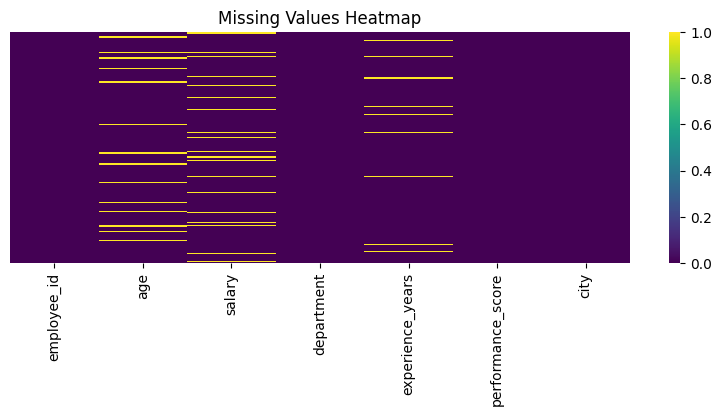

In [28]:
plt.figure(figsize=(10, 3))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [29]:
df_clean = df.drop_duplicates(subset=['employee_id'], keep='first')

print(f"Before: {df.shape[0]}, After: {df_clean.shape[0]}")

Before: 205, After: 200


In [30]:
df_filled = df_clean.copy()
df_filled['age'] = df_filled['age'].fillna(df_filled['age'].median())
df_filled['salary'] = df_filled['salary'].fillna(df_filled['salary'].mean())
df_filled['experience_years'] = df_filled['experience_years'].fillna(0)
print(df_filled.isnull().sum())

employee_id          0
age                  0
salary               0
department           0
experience_years     0
performance_score    0
city                 0
dtype: int64


In [31]:
df_filled['city'] = df_filled['city'].str.title()
df_filled['city'] = df_filled['city'].replace('ktm', 'kathmandu')
df_filled['city'] = df_filled['city'].fillna('Unknown')
print("After:", df_filled['city'].unique())

After: ['Pokhara' 'Pkr' 'Kathmandu' 'Bhaktapur' 'Ktm' 'Nan']


# Data Tranformation

In [32]:
df_transform = df_filled.copy()

In [33]:
le = LabelEncoder()
df_transform['dept_encoded'] = le.fit_transform(df_transform['department'])
print(dict(zip(le.classes_, range(len(le.classes_)))))

{'Engineering': 0, 'Finance': 1, 'HR': 2, 'Marketing': 3, 'Sales': 4}


In [34]:
dept_dummies = pd.get_dummies(df_transform['department'], prefix='dept')
dept_dummies.head()

,dept_Engineering,dept_Finance,dept_HR,dept_Marketing,dept_Sales
0,False,True,False,False,False
1,False,False,True,False,False
2,False,False,False,False,True
3,False,False,True,False,False
4,False,False,False,False,True


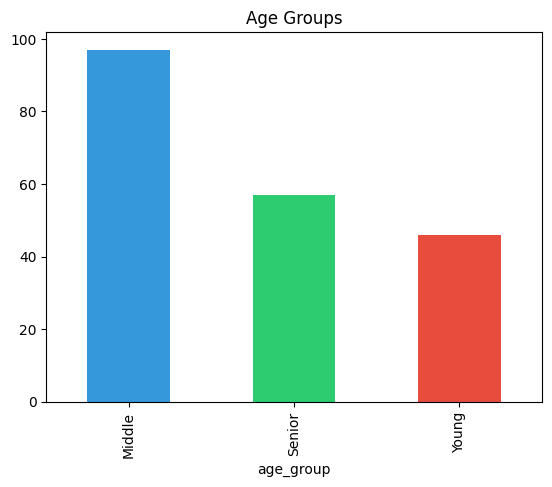

In [35]:
df_transform['age_group'] = pd.cut(df_transform['age'], bins=[0,30,50,100], labels=['Young','Middle','Senior'])
df_transform['age_group'].value_counts().plot(kind='bar', color=['#3498db','#2ecc71','#e74c3c'])
plt.title('Age Groups')
plt.show()

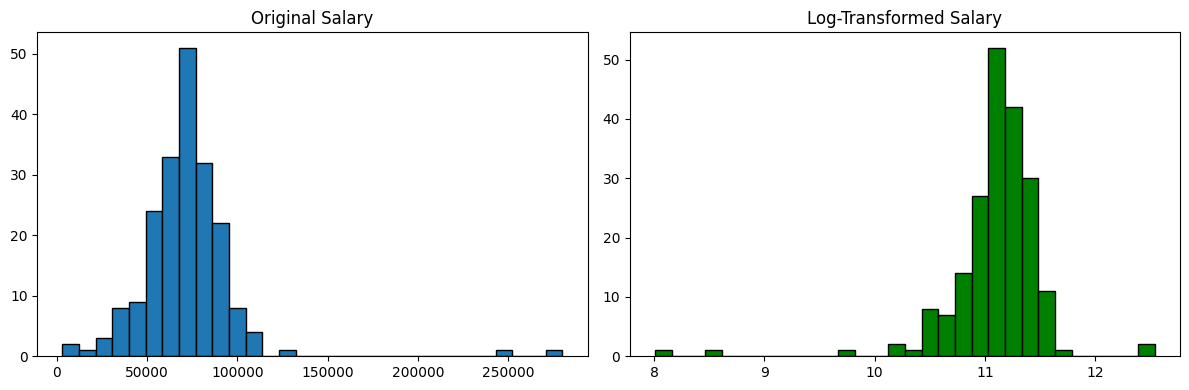

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df_transform['salary'].dropna(), bins=30, edgecolor='black')
axes[0].set_title('Original Salary')
axes[1].hist(np.log1p(df_transform['salary'][df_transform['salary']>0]), bins=30, edgecolor='black', color='green')
axes[1].set_title('Log-Transformed Salary')
plt.tight_layout()
plt.show()

# Normalization & Standardization

In [37]:
numeric_cols = ['age', 'salary', 'experience_years', 'performance_score']
df_numeric = df_transform[numeric_cols].copy()
df_numeric.describe()

,age,salary,experience_years,performance_score
count,200.000000,200.000000,200.000000,200.000000
mean,43.045000,71139.310378,11.825000,5.389547
std,13.276835,27143.384103,7.766335,2.556356
min,15.000000,3000.000000,0.000000,1.041688
25%,32.000000,59077.721616,5.000000,3.052808
50%,44.000000,71139.310378,12.500000,5.289432
75%,53.000000,80462.533850,18.000000,7.630376
max,98.000000,280000.000000,24.000000,9.971868


In [38]:
scaler_mm = MinMaxScaler()
df_normalized = pd.DataFrame(scaler_mm.fit_transform(df_numeric), columns=numeric_cols)
print("Min-Max Normalized (0-1):")
print(df_normalized.describe())

Min-Max Normalized (0-1):
              age      salary  experience_years  performance_score
count  200.000000  200.000000        200.000000         200.000000
mean     0.337892    0.245990          0.492708           0.486873
std      0.159962    0.097991          0.323597           0.286260
min      0.000000    0.000000          0.000000           0.000000
25%      0.204819    0.202447          0.208333           0.225205
50%      0.349398    0.245990          0.520833           0.475662
75%      0.457831    0.279648          0.750000           0.737800
max      1.000000    1.000000          1.000000           1.000000


In [39]:
scaler_std = StandardScaler()
df_standardized = pd.DataFrame(scaler_std.fit_transform(df_numeric), columns=numeric_cols)
print("Z-Score Standardized:")
print(df_standardized.describe())

Z-Score Standardized:
                age        salary  experience_years  performance_score
count  2.000000e+02  2.000000e+02      2.000000e+02       2.000000e+02
mean  -1.376677e-16 -1.421085e-16      6.217249e-17      -2.930989e-16
std    1.002509e+00  1.002509e+00      1.002509e+00       1.002509e+00
min   -2.117626e+00 -2.516646e+00     -1.526418e+00      -1.705072e+00
25%   -8.339877e-01 -4.454808e-01     -8.809982e-01      -9.163840e-01
50%    7.211030e-02  0.000000e+00      8.713169e-02      -3.926170e-02
75%    7.516838e-01  3.443424e-01      7.970936e-01       8.787714e-01
max    4.149551e+00  7.714027e+00      1.571597e+00       1.797019e+00


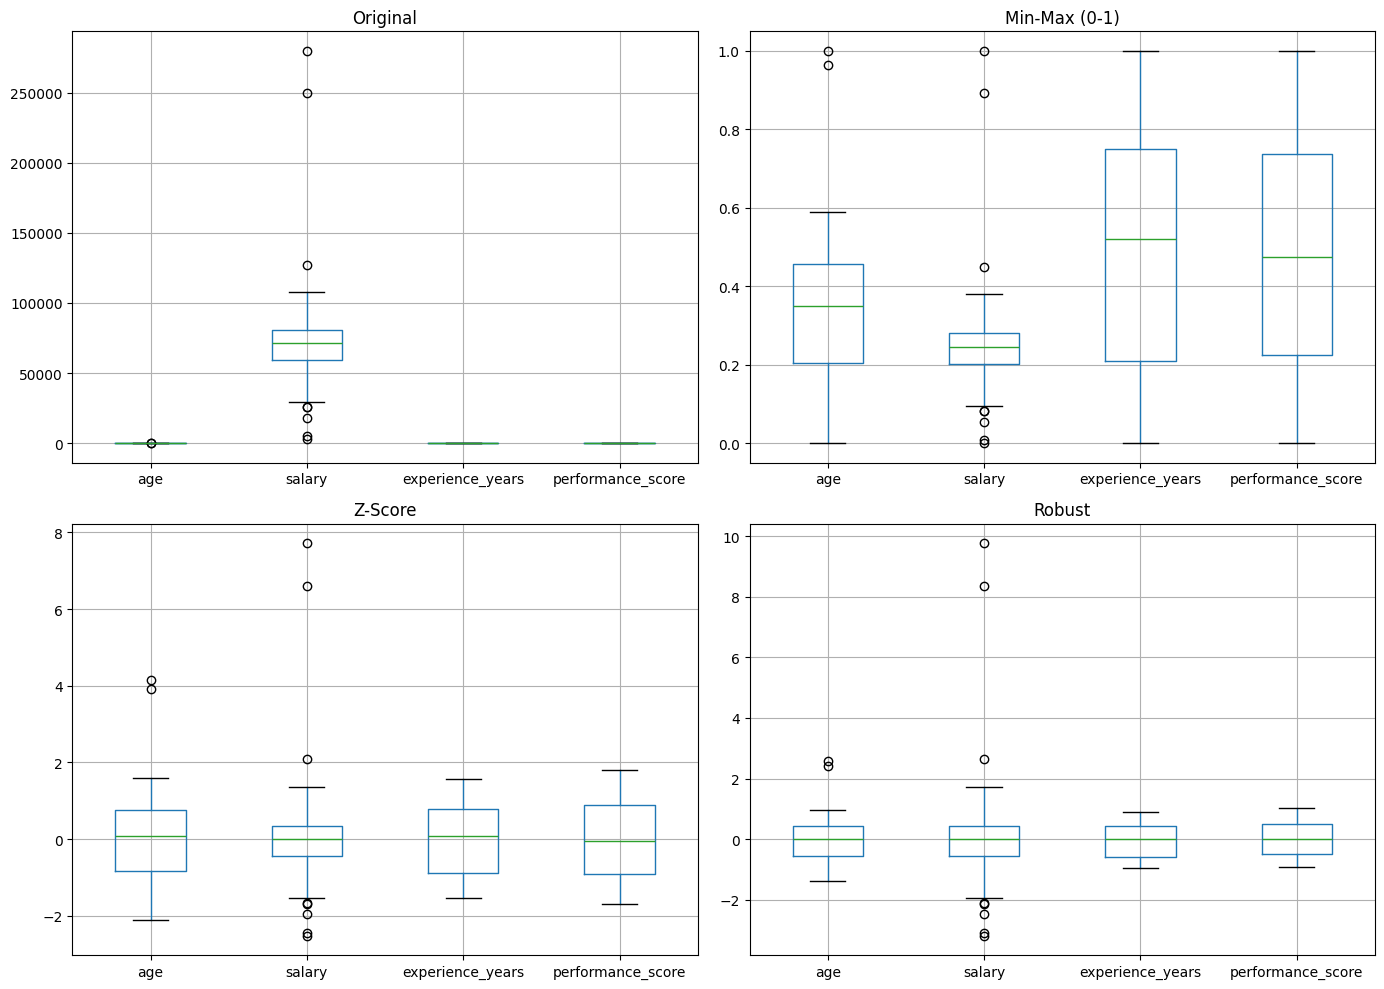

In [40]:
df_robust = pd.DataFrame(RobustScaler().fit_transform(df_numeric), columns=numeric_cols)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
df_numeric.boxplot(ax=axes[0,0]); axes[0,0].set_title('Original')
df_normalized.boxplot(ax=axes[0,1]); axes[0,1].set_title('Min-Max (0-1)')
df_standardized.boxplot(ax=axes[1,0]); axes[1,0].set_title('Z-Score')
df_robust.boxplot(ax=axes[1,1]); axes[1,1].set_title('Robust')
plt.tight_layout()
plt.show()

# Outlier Detection

In [41]:
df_outliers = df_transform.copy()

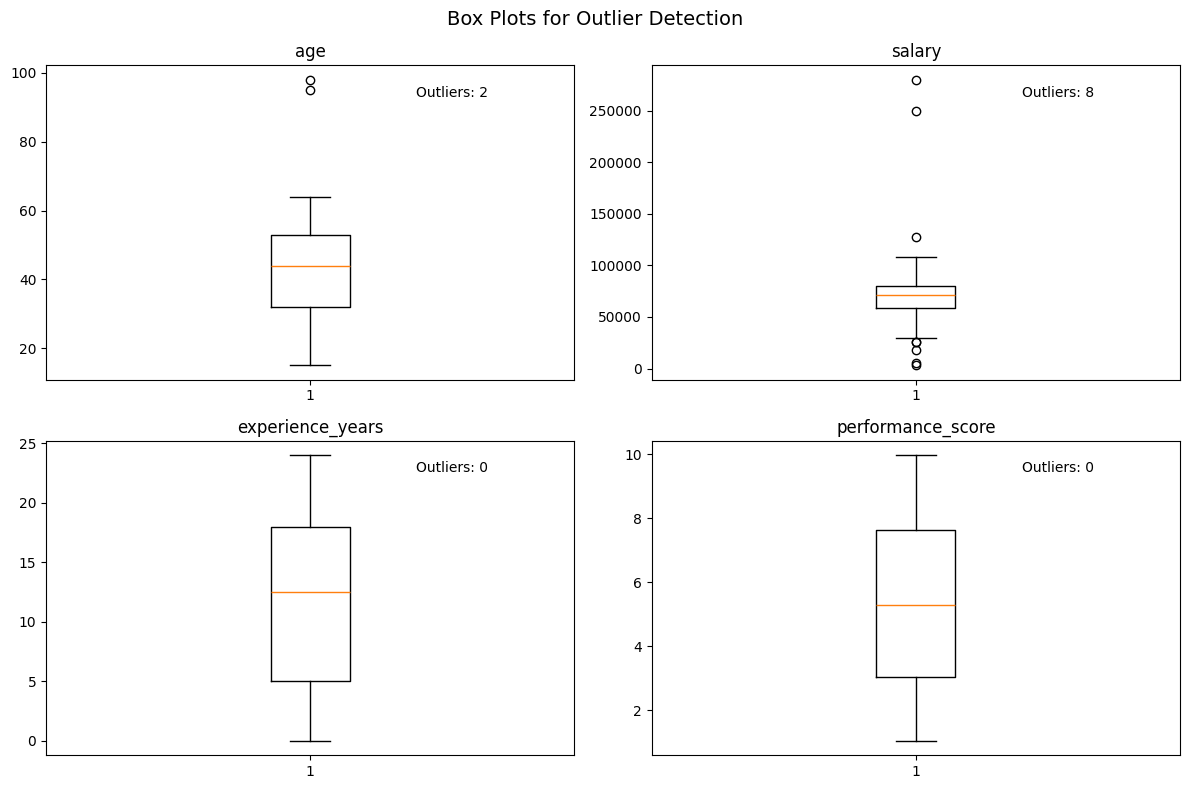

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flatten(), ['age', 'salary', 'experience_years', 'performance_score']):
    ax.boxplot(df_outliers[col].dropna())
    ax.set_title(f'{col}')
    q1, q3 = df_outliers[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = ((df_outliers[col] < q1-1.5*iqr) | (df_outliers[col] > q3+1.5*iqr)).sum()
    ax.text(0.7, 0.9, f'Outliers: {outliers}', transform=ax.transAxes)
plt.suptitle('Box Plots for Outlier Detection', fontsize=14)
plt.tight_layout()
plt.show()

In [43]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_mask = (data[column] < lower) | (data[column] > upper)
    return {'Q1': Q1, 'Q3': Q3, 'IQR': IQR, 'lower': lower, 'upper': upper,
            'count': outliers_mask.sum(), 'mask': outliers_mask}
for col in ['age', 'salary']:
    r = detect_outliers_iqr(df_outliers, col)
    print(f"{col}: Bounds [{r['lower']:.1f}, {r['upper']:.1f}], Outliers: {r['count']}")

age: Bounds [0.5, 84.5], Outliers: 2
salary: Bounds [27000.5, 112539.8], Outliers: 8


In [44]:
def detect_outliers_zscore(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    z_scores = (data[column] - mean) / std
    outliers_mask = np.abs(z_scores) > threshold
    return {'mean': mean, 'std': std, 'z_scores': z_scores,
            'count': outliers_mask.sum(), 'mask': outliers_mask}
for thresh in [2, 2.5, 3]:
    r = detect_outliers_zscore(df_outliers, 'salary', thresh)
    print(f"Threshold {thresh}: {r['count']} outliers")

Threshold 2: 5 outliers
Threshold 2.5: 3 outliers
Threshold 3: 2 outliers


IQR Method: 8 outliers
Z-Score (|z|>3): 2 outliers


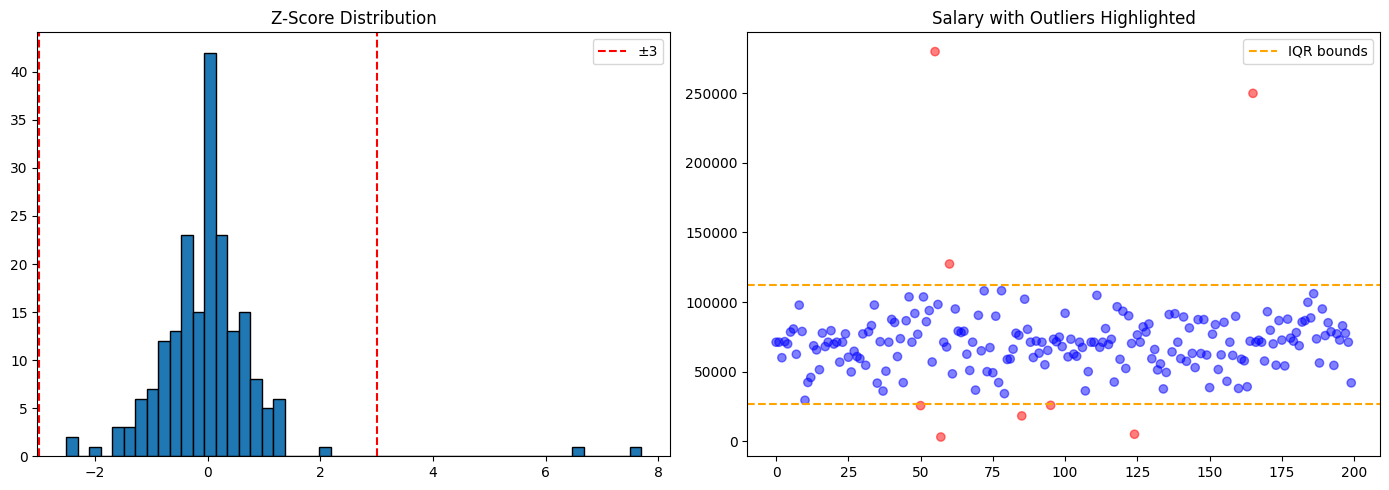

In [45]:
iqr_r = detect_outliers_iqr(df_outliers, 'salary')
zscore_r = detect_outliers_zscore(df_outliers, 'salary', 3)
print(f"IQR Method: {iqr_r['count']} outliers")
print(f"Z-Score (|z|>3): {zscore_r['count']} outliers")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(zscore_r['z_scores'].dropna(), bins=50, edgecolor='black')
axes[0].axvline(3, color='red', linestyle='--', label='±3')
axes[0].axvline(-3, color='red', linestyle='--')
axes[0].set_title('Z-Score Distribution'); axes[0].legend()
colors = ['red' if x else 'blue' for x in iqr_r['mask']]
axes[1].scatter(range(len(df_outliers)), df_outliers['salary'], c=colors, alpha=0.5)
axes[1].axhline(iqr_r['upper'], color='orange', linestyle='--', label='IQR bounds')
axes[1].axhline(iqr_r['lower'], color='orange', linestyle='--')
axes[1].set_title('Salary with Outliers Highlighted'); axes[1].legend()
plt.tight_layout()
plt.show()

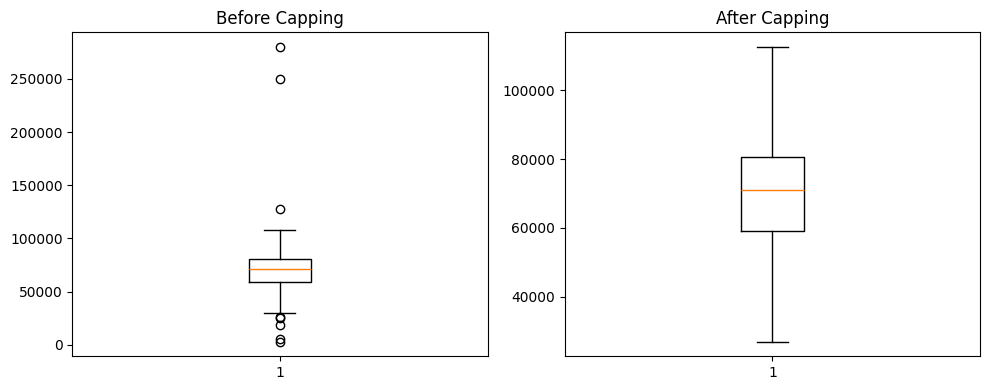

In [23]:
def cap_outliers(data, column):
    Q1, Q3 = data[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    return np.clip(data[column], Q1 - 1.5*IQR, Q3 + 1.5*IQR)
df_outliers['salary_capped'] = cap_outliers(df_outliers, 'salary')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].boxplot(df_outliers['salary'].dropna()); axes[0].set_title('Before Capping')
axes[1].boxplot(df_outliers['salary_capped']); axes[1].set_title('After Capping')
plt.tight_layout()
plt.show()

# Complete Pipeline

In [24]:
def preprocess_pipeline(data):
    df_p = data.copy()
    df_p = df_p.drop_duplicates(subset=['employee_id'])
    df_p['age'] = df_p['age'].fillna(df_p['age'].median())
    df_p['salary'] = df_p['salary'].fillna(df_p['salary'].mean())
    df_p['experience_years'] = df_p['experience_years'].fillna(0)
    df_p['city'] = df_p['city'].str.title().replace('L.A.', 'Los Angeles').fillna('Unknown')
    for col in ['salary', 'age']:
        Q1, Q3 = df_p[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        df_p[col] = np.clip(df_p[col], Q1-1.5*IQR, Q3+1.5*IQR)
    num_cols = ['age', 'salary', 'experience_years', 'performance_score']
    scaler = StandardScaler()
    df_p[[f'{c}_scaled' for c in num_cols]] = scaler.fit_transform(df_p[num_cols])
    df_p['dept_encoded'] = LabelEncoder().fit_transform(df_p['department'])
    df_p = pd.concat([df_p, pd.get_dummies(df_p['city'], prefix='city')], axis=1)
    return df_p
df_final = preprocess_pipeline(df)
print(f"Final shape: {df_final.shape}")
df_final.head()

Final shape: (200, 18)


,employee_id,age,salary,department,experience_years,performance_score,city,age_scaled,salary_scaled,experience_years_scaled,performance_score_scaled,dept_encoded,city_Bhaktapur,city_Kathmandu,city_Ktm,city_Nan,city_Pkr,city_Pokhara
0,16,24.0,71139.310378,Finance,23.0,2.209732,Pokhara,-1.477943,0.071951,1.442514,-1.247008,1,False,False,False,False,False,True
1,10,32.0,71139.310378,HR,18.0,6.231144,Pkr,-0.853185,0.071951,0.797094,0.330044,2,False,False,False,False,True,False
2,101,28.0,59992.991840,Sales,1.0,5.158052,Pokhara,-1.165564,-0.539689,-1.397334,-0.090784,4,False,False,False,False,False,True
3,133,60.0,71558.184661,HR,24.0,8.225681,Pokhara,1.333468,0.094936,1.571597,1.112228,2,False,False,False,False,False,True
4,69,44.0,69915.472096,Sales,4.0,6.580655,Kathmandu,0.083952,0.004794,-1.010082,0.467109,4,False,True,False,False,False,False
